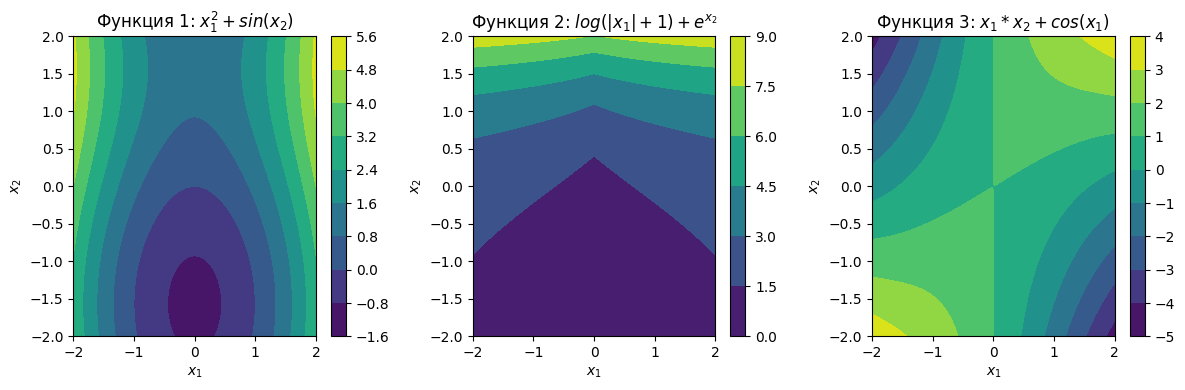

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

def func1_np(x1, x2):
    return x1**2 + np.sin(x2)

def func2_np(x1, x2):
    return np.log(np.abs(x1) + 1) + np.exp(x2)

def func3_np(x1, x2):
    return x1 * x2 + np.cos(x1)

x1_vals = np.linspace(-2, 2, 100)
x2_vals = np.linspace(-2, 2, 100)


x1_grid, x2_grid = np.meshgrid(x1_vals, x2_vals)

y1 = func1_np(x1_grid, x2_grid)
y2 = func2_np(x1_grid, x2_grid)
y3 = func3_np(x1_grid, x2_grid)


plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.contourf(x1_grid, x2_grid, y1, cmap='viridis')
plt.title("Функция 1: $x_1^2 + sin(x_2)$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.colorbar()


plt.subplot(132)
plt.contourf(x1_grid, x2_grid, y2, cmap='viridis')
plt.title("Функция 2: $log(|x_1|+1) + e^{x_2}$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.colorbar()


plt.subplot(133)
plt.contourf(x1_grid, x2_grid, y3, cmap='viridis')
plt.title("Функция 3: $x_1 * x_2 + cos(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.colorbar()

plt.tight_layout()
plt.show()


Берем три функции для создания нелинейной регрессии. 
1 - Квадратичная зависимость + синус
2 - Логарифм + экспонента
3 - Произведение + косинус


In [10]:
def generate_data(func, n_samples=1000):
    x1 = torch.rand(n_samples) * 4 - 2
    x2 = torch.rand(n_samples) * 4 - 2
    noise = torch.randn(n_samples) * 0.1
    y = func(x1, x2) + noise
    X = torch.stack([x1, x2], dim=1)
    return X, y

def func1(x1, x2):
    return x1**2 + torch.sin(x2)

def func2(x1, x2):
    return torch.log(torch.abs(x1) + 1) + torch.exp(x2)

def func3(x1, x2):
    return x1 * x2 + torch.cos(x1)

In [3]:
class RegressModel(nn.Module):
    def __init__(self, batch_norm=False, dropout=False):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(64) if batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm1d(32) if batch_norm else nn.Identity()
        self.dropout = nn.Dropout(0.3) if dropout else nn.Identity()

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Делаем модель. У нас тут 3 полносвязных слоя. Функция активации relu, опциональный бачнорм и дропаут.

In [8]:
def train_model(model, train_loader, val_loader, epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return train_losses, val_losses

In [5]:
batch_sizes = [16, 32, 64, 128, 256]
functions = [func1, func2, func3]

best_batch_size = None
best_val_loss = float("inf")

In [6]:
for batch_size in batch_sizes:
    print(f"Тест батча: {batch_size}")
    
    for i, func in enumerate(functions):
        X, y = generate_data(func)
        X_train, X_val = torch.tensor(X[:800], dtype=torch.float32), torch.tensor(X[800:], dtype=torch.float32)
        y_train, y_val = torch.tensor(y[:800], dtype=torch.float32), torch.tensor(y[800:], dtype=torch.float32)
        
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
        
        model = RegressModel(batch_norm=True)
        train_losses, val_losses = train_model(model, train_loader, val_loader)
        print(val_losses[-1], best_val_loss)
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_batch_size = batch_size

print(f"Лучший размер батча по итогу: {best_batch_size}")

Тест батча: 16


C:\Users\Zina\AppData\Local\Temp\ipykernel_7324\3974234185.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_val = torch.tensor(X[:800], dtype=torch.float32), torch.tensor(X[800:], dtype=torch.float32)
C:\Users\Zina\AppData\Local\Temp\ipykernel_7324\3974234185.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train, y_val = torch.tensor(y[:800], dtype=torch.float32), torch.tensor(y[800:], dtype=torch.float32)


0.11486258787604478 inf


C:\Users\Zina\AppData\Local\Temp\ipykernel_7324\3974234185.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_val = torch.tensor(X[:800], dtype=torch.float32), torch.tensor(X[800:], dtype=torch.float32)
C:\Users\Zina\AppData\Local\Temp\ipykernel_7324\3974234185.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train, y_val = torch.tensor(y[:800], dtype=torch.float32), torch.tensor(y[800:], dtype=torch.float32)


0.2560986257516421 0.11486258787604478
0.026342902762385514 0.11486258787604478
Тест батча: 32
0.0509204055581774 0.026342902762385514
0.032967738275017054 0.026342902762385514
0.0213039524054953 0.026342902762385514
Тест батча: 64
0.03770208964124322 0.0213039524054953
0.02145095495507121 0.0213039524054953
0.027176174800843 0.0213039524054953
Тест батча: 128
0.034873184747993946 0.0213039524054953
0.022940839640796185 0.0213039524054953
0.022962303832173347 0.0213039524054953
Тест батча: 256
0.02827451191842556 0.0213039524054953
0.05175038427114487 0.0213039524054953
0.03979743644595146 0.0213039524054953
Лучший размер батча по итогу: 32


Тест: Нет батчнорма, нет дропаута


C:\Users\Zina\AppData\Local\Temp\ipykernel_7324\3312168458.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_val = torch.tensor(X[:800], dtype=torch.float32), torch.tensor(X[800:], dtype=torch.float32)
C:\Users\Zina\AppData\Local\Temp\ipykernel_7324\3312168458.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train, y_val = torch.tensor(y[:800], dtype=torch.float32), torch.tensor(y[800:], dtype=torch.float32)


Тест: Только батчнорм
Тест: Только дропаут
Тест: И батчнорм и дропаут


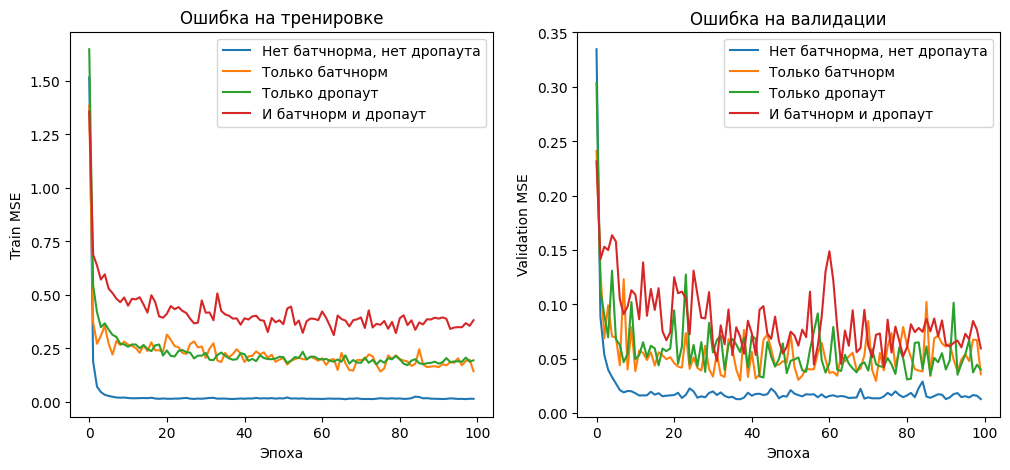

In [12]:
configs = [
    (False, False, "Нет батчнорма, нет дропаута"),
    (True, False, "Только батчнорм"),
    (False, True, "Только дропаут"),
    (True, True, "И батчнорм и дропаут")
]
train_losses_dict = {}
val_losses_dict = {}

for batch_norm, dropout, label in configs:
    print(f"Тест: {label}")
    all_train_losses = []
    all_val_losses = []
    for i, func in enumerate(functions):
        X, y = generate_data(func)
        X_train, X_val = torch.tensor(X[:800], dtype=torch.float32), torch.tensor(X[800:], dtype=torch.float32)
        y_train, y_val = torch.tensor(y[:800], dtype=torch.float32), torch.tensor(y[800:], dtype=torch.float32)
        
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=best_batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=best_batch_size)
        
        model = RegressModel(batch_norm=batch_norm, dropout=dropout)
        train_losses, val_losses = train_model(model, train_loader, val_loader)
        
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
    avg_train_losses = np.mean(all_train_losses, axis=0)
    avg_val_losses = np.mean(all_val_losses, axis=0)

    train_losses_dict[label] = avg_train_losses
    val_losses_dict[label] = avg_val_losses
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
for label, losses in train_losses_dict.items():
    plt.plot(losses, label=label)
plt.xlabel("Эпоха")
plt.ylabel("Train MSE")
plt.title("Ошибка на тренировке")
plt.legend()


plt.subplot(1, 2, 2)
for label, losses in val_losses_dict.items():
    plt.plot(losses, label=label)
plt.xlabel("Эпоха")
plt.ylabel("Validation MSE")
plt.title("Ошибка на валидации")
plt.legend()

plt.show()


Видим, что MSE на каждой эпохе уменьшается. 
При отстутсвии батчнорма и дропаута в этом случае получается самое стабильное обучение, но на практике такой подход часто приводит к переобучению.
Далее явно видим работу дропаута, где обучение модели и ее предстказания скачут.
Хуже всего значения получились применении обоих способах.
Тут можно сделать вывод, что не всегда просто добавлении батчнорма или дроптауте поможет сделать модель лучше, нужно понимать архитектуру сети и с какими данными мы работаем.
